In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from PIL import Image
from sklearn.model_selection import train_test_split
from keras import Model
from keras.layers import Input, Conv2D, Activation, BatchNormalization, MaxPooling2D, Flatten, Dense, Dropout, Concatenate
from keras.optimizers import Adam
from ipywidgets import interact
import ipywidgets as widgets
from keras.initializers import RandomNormal
from keras.callbacks import EarlyStopping, ModelCheckpoint
from keras.models import load_model
import keras
from sklearn.linear_model import LinearRegression

Using TensorFlow backend.


In [2]:
ls

'#2 DL Model Capstone 2 HED.ipynb'
'#2 DL Model Capstone 2.ipynb'
'#2 DL Model Capstone 2 v2_left_image.ipynb'
'#2 DL Model Capstone 2 v2-right_Image.ipynb'
'Step 1. Data Wrangling'/
 ThinSectionAE-model-01-0.0860-0.1338.hdf5
 ThinSectionAE-model-01-0.0862-0.0460.hdf5
 ThinSectionAE-model-01-0.0880-0.1034.hdf5
 ThinSectionAE-model-01-0.0899-0.0723.hdf5
 ThinSectionAE-model-01-0.0917-0.1795.hdf5
 ThinSectionAE-model-01-0.0925-0.0549.hdf5
 ThinSectionAE-model-01-0.0934-0.0980.hdf5
 ThinSectionAE-model-01-0.0959-0.3251.hdf5
 ThinSectionAE-model-01-0.0981-0.0445.hdf5
 ThinSectionAE-model-01-0.1068-0.0471.hdf5
 ThinSectionAE-model-01-0.1071-0.0381.hdf5
 ThinSectionAE-model-01-0.2616-0.2548.hdf5
 ThinSectionAE-model-01-107.7245-98.0494.hdf5
 ThinSectionAE-model-01-13.6189-28.3509.hdf5
 ThinSectionAE-model-01-15.0691-28.5317.hdf5
 ThinSectionAE-model-01-15.9693-32.4250.hdf5
 ThinSectionAE-model-01-20.2686-38.0556.hdf5
 ThinSectionAE-model-01-21.8554-39.5578.hdf5
 ThinSectionAE-model-01-32.143

In [3]:
dir_path = 'Step 1. Data Wrangling/'

In [4]:
df_wellA = pd.read_csv(dir_path+'DATA_for_DL_Well_A_data.csv')
df_wellA

,Unnamed: 0,"Depth, m","Porosity, pc",File Name
0,0,3837.55,10.8,15_9_19_A\15_9_19_A_p2_3837.55.png
1,1,3838.50,17.2,15_9_19_A\15_9_19_A_p2_3838.50.png
2,2,3839.40,12.7,15_9_19_A\15_9_19_A_p3_3839.40.png
3,3,3840.45,21.0,15_9_19_A\15_9_19_A_p3_3840.45.png
4,4,3841.45,22.1,15_9_19_A\15_9_19_A_p4_3841.45.png
...,...,...,...,...
147,147,3995.50,18.2,15_9_19_A\15_9_19_A_p79_3995.50.png
148,148,3996.40,15.7,15_9_19_A\15_9_19_A_p79_3996.40.png
149,149,3997.50,11.7,15_9_19_A\15_9_19_A_p80_3997.50.png
150,150,3998.45,15.4,15_9_19_A\15_9_19_A_p80_3998.45.png


In [5]:
X_dataA=[]
y_dataA=[]
for ind in df_wellA.index:
    y_dataA.append(df_wellA['Porosity, pc'][ind])
    im = Image.open((dir_path+df_wellA['File Name'][ind][:-4]).replace('\\','/')+'_right.jpg')
    X_dataA.append(np.array(im))
    #print(ind,df_wellA['Porosity, pc'][ind],df_wellA['File Name'][ind])

In [6]:
y_dataA=np.array(y_dataA)/36
y_dataA.shape

(152,)

In [7]:
X_dataA=np.array(X_dataA)/255
X_dataA.shape

(152, 1536, 1024, 3)

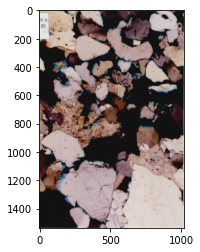

In [8]:
plt.imshow(X_dataA[1,:,:,:])

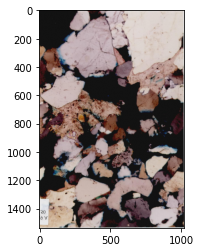

In [9]:
plt.imshow(np.flip(X_dataA,axis=1)[1,:,:,:])

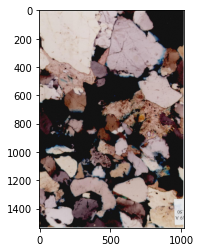

In [10]:
plt.imshow(np.flip(np.flip(X_dataA,axis=1),axis=2)[1,:,:,:])

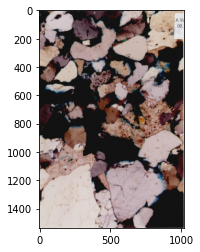

In [11]:
plt.imshow(np.flip(X_dataA,axis=2)[1,:,:,:])

In [12]:
X_dataA=np.concatenate((X_dataA,np.flip(X_dataA,axis=1),np.flip(X_dataA,axis=2),np.flip(np.flip(X_dataA,axis=1),axis=2)),axis=0)
y_dataA=np.concatenate((y_dataA,y_dataA,y_dataA,y_dataA),axis=0)
print(X_dataA.shape)
print(y_dataA.shape)

(608, 1536, 1024, 3)
(608,)


In [ ]:
def plot_thin_section(item):
    
    fig, ax = plt.subplots(figsize=(5, 5),frameon=False)
    
    ax.title.set_text('Porosity # '+str(round(y_dataA[item],2)))
    ax.imshow(X_dataA[item,:,:,:])

In [ ]:
sliders_item = widgets.IntSlider(min=0, max=X_dataA.shape[0], step=1, value=0, description='Item # ')
interact(plot_thin_section, item=sliders_item)

In [13]:
X_train, X_test, y_train, y_test = train_test_split(X_dataA, y_dataA, test_size=0.10, random_state=42)
print(X_train.shape)
print(X_test.shape)
print(y_train.shape)
print(y_test.shape)

(547, 1536, 1024, 3)
(61, 1536, 1024, 3)
(547,)
(61,)


In [14]:
# define an encoder block
def define_encoder_block(layer_in, n_filters, stride=(2,2), batchnorm=True):
    
    # weight initialization
    init = RandomNormal(stddev=0.02)
    
    # add downsampling layer
    g = Conv2D(n_filters, (2,2), strides=stride, padding='same', kernel_initializer=init)(layer_in)
    
    g = MaxPooling2D()(g)
    
    # conditionally add batch normalization
    if batchnorm:
        g = BatchNormalization()(g, training=True)
    
    
    # leaky relu activation
    #g = LeakyReLU(alpha=0.2)(g)
    g = Activation('relu')(g)
    
    return g
 
 
    
# define the standalone generator model
def define_generator(image_shape):
    
    # weight initialization
    init = RandomNormal(stddev=0.02)
    
    # image input
    in_image = Input(shape=image_shape)
    
    # encoder model
    e1 = define_encoder_block(in_image, 64, stride=(3,2), batchnorm=False)
    e2 = define_encoder_block(e1, 128)
    e3 = define_encoder_block(e2, 256)
    e4 = define_encoder_block(e3, 512)
    
    # bottleneck, no batch norm and relu
    b = Conv2D(512, (2,2), strides=(2,2), padding='same', kernel_initializer=init)(e4)
    b = Activation('relu')(b)
     
    x = Flatten()(b)
    x = Dense(128)(x)
    x = Activation("relu")(x)
    x = BatchNormalization()(x)
    x = Dropout(0.25)(x)
    
    # apply another FC layer, this one to match the number of nodes
    # coming out of the MLP
    x = Dense(64)(x)
    x = Activation("relu")(x)
    x = BatchNormalization()(x)
    x = Dropout(0.25)(x)
    
    # check to see if the regression node should be added
    #if regress:
        #x = Dense(1, activation="linear")(x)
    out_image = Dense(1, activation="sigmoid")(x)

    # define model
    model = Model(in_image, out_image)
    
    return model

In [15]:
keras.backend.clear_session()
# define input shape based on the loaded dataset
image_shape = X_train[0].shape

g_model = define_generator(image_shape)

# compile model
opt = Adam(lr=0.001, beta_1=0.5)

g_model.compile(loss='mean_absolute_percentage_error', optimizer=opt, metrics=['mse']) #, 'mae', 'mean_absolute_percentage_error'

In [16]:
g_model.summary()

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 1536, 1024, 3)     0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 512, 512, 64)      832       
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 256, 256, 64)      0         
_________________________________________________________________
activation_1 (Activation)    (None, 256, 256, 64)      0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 128, 128, 128)     32896     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 64, 64, 128)       0         
_________________________________________________________________
batch_normalization_1 (Batch (None, 64, 64, 128)       512 

In [17]:
es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=50)
filepath = "ThinSectionAE_right-model-{epoch:02d}-{loss:.4f}-{val_loss:.4f}.hdf5"
checkpoint = ModelCheckpoint(filepath, monitor='val_loss', verbose=1, save_best_only=True, mode='min',period=1)

history = g_model.fit(X_train, y_train,
          epochs=100,
          batch_size=32,
          shuffle=True,
          verbose=1,
          validation_data=(X_test, y_test),
          callbacks=[checkpoint])

Train on 547 samples, validate on 61 samples
Epoch 1/100
547/547 [==============================] - 77s 141ms/step - loss: 67.7328 - mse: 0.0816 - val_loss: 77.2345 - val_mse: 0.0701

Epoch 00001: val_loss improved from inf to 77.23447, saving model to ThinSectionAE_left-model-01-67.7328-77.2345.hdf5
Epoch 2/100
547/547 [==============================] - 71s 130ms/step - loss: 53.8265 - mse: 0.0603 - val_loss: 39.8035 - val_mse: 0.0465

Epoch 00002: val_loss improved from 77.23447 to 39.80354, saving model to ThinSectionAE_left-model-02-53.8265-39.8035.hdf5
Epoch 3/100
547/547 [==============================] - 69s 126ms/step - loss: 45.3750 - mse: 0.0471 - val_loss: 132.6522 - val_mse: 0.2098

Epoch 00003: val_loss did not improve from 39.80354
Epoch 4/100
547/547 [==============================] - 71s 129ms/step - loss: 43.5622 - mse: 0.0446 - val_loss: 106.2786 - val_mse: 0.1382

Epoch 00004: val_loss did not improve from 39.80354
Epoch 5/100
547/547 [==============================]

547/547 [==============================] - 89s 162ms/step - loss: 19.2835 - mse: 0.0113 - val_loss: 29.5026 - val_mse: 0.0274

Epoch 00040: val_loss did not improve from 25.36492
Epoch 41/100
547/547 [==============================] - 86s 156ms/step - loss: 19.1047 - mse: 0.0105 - val_loss: 37.0982 - val_mse: 0.0485

Epoch 00041: val_loss did not improve from 25.36492
Epoch 42/100
547/547 [==============================] - 87s 160ms/step - loss: 20.9425 - mse: 0.0126 - val_loss: 28.6405 - val_mse: 0.0287

Epoch 00042: val_loss did not improve from 25.36492
Epoch 43/100
547/547 [==============================] - 88s 162ms/step - loss: 17.6923 - mse: 0.0096 - val_loss: 27.8142 - val_mse: 0.0272

Epoch 00043: val_loss did not improve from 25.36492
Epoch 44/100
547/547 [==============================] - 87s 160ms/step - loss: 18.7922 - mse: 0.0097 - val_loss: 29.0987 - val_mse: 0.0308

Epoch 00044: val_loss did not improve from 25.36492
Epoch 45/100
547/547 [==============================]

547/547 [==============================] - 87s 159ms/step - loss: 12.5945 - mse: 0.0048 - val_loss: 23.7494 - val_mse: 0.0162

Epoch 00082: val_loss did not improve from 23.25268
Epoch 83/100
547/547 [==============================] - 91s 166ms/step - loss: 13.1482 - mse: 0.0051 - val_loss: 25.4144 - val_mse: 0.0181

Epoch 00083: val_loss did not improve from 23.25268
Epoch 84/100
547/547 [==============================] - 86s 157ms/step - loss: 11.6279 - mse: 0.0041 - val_loss: 27.1193 - val_mse: 0.0201

Epoch 00084: val_loss did not improve from 23.25268
Epoch 85/100
547/547 [==============================] - 86s 157ms/step - loss: 12.5702 - mse: 0.0047 - val_loss: 27.1442 - val_mse: 0.0228

Epoch 00085: val_loss did not improve from 23.25268
Epoch 86/100
547/547 [==============================] - 92s 168ms/step - loss: 12.9443 - mse: 0.0052 - val_loss: 25.2592 - val_mse: 0.0188

Epoch 00086: val_loss did not improve from 23.25268
Epoch 87/100
547/547 [==============================]

In [21]:
ls

'#2 DL Model Capstone 2 HED.ipynb'
'#2 DL Model Capstone 2.ipynb'
'#2 DL Model Capstone 2 v2_left_image.ipynb'
'#2 DL Model Capstone 2 v2-right_Image.ipynb'
'Step 1. Data Wrangling'/
 ThinSectionAE_left-model-01-67.7328-77.2345.hdf5
 ThinSectionAE_left-model-01-71.2402-67.4579.hdf5
 ThinSectionAE_left-model-02-53.8265-39.8035.hdf5
 ThinSectionAE_left-model-04-52.0984-47.0549.hdf5
 ThinSectionAE_left-model-05-50.6716-36.6940.hdf5
 ThinSectionAE_left-model-14-30.9124-37.1557.hdf5
 ThinSectionAE_left-model-14-39.5622-31.2154.hdf5
 ThinSectionAE_left-model-17-29.8826-33.7616.hdf5
 ThinSectionAE_left-model-18-27.5152-29.0510.hdf5
 ThinSectionAE_left-model-19-36.5394-29.7067.hdf5
 ThinSectionAE_left-model-20-36.6715-25.7717.hdf5
 ThinSectionAE_left-model-28-32.2335-24.6727.hdf5
 ThinSectionAE_left-model-30-29.4121-21.1781.hdf5
 ThinSectionAE_left-model-32-22.8244-28.1822.hdf5
 ThinSectionAE_left-model-35-21.6647-28.0172.hdf5
 ThinSectionAE_left-model-36-20.6497-27.0750.hdf5
 ThinSectionAE_le

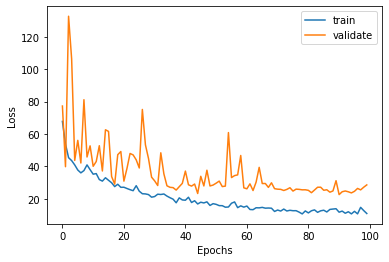

In [18]:
# plot training history
plt.plot(g_model.history.history['loss'], label='train')
plt.plot(g_model.history.history['val_loss'], label='validate')
plt.xlabel('Epochs')
plt.ylabel('Loss')
#plt.title('Learning_rate=Variable')
plt.legend()
plt.show()

coefficient of determination: 0.6027393169816591


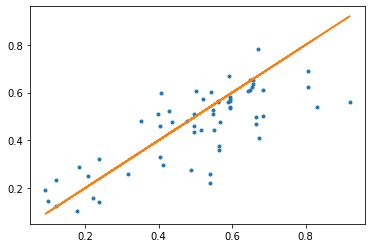

In [22]:
model = load_model('ThinSectionAE_left-model-91-11.7325-22.5732.hdf5') #dropout=0.5, max pooling added, lr -.001, filter (2,2) , mpe, batch size 8
X_test_predict = model.predict(X_test)
plt.plot(y_test,X_test_predict,'.')
plt.plot(y_test,y_test,'-')
linear = LinearRegression()
linear.fit(y_test.reshape(X_test_predict.shape[0],X_test_predict.shape[1]),X_test_predict.reshape(X_test_predict.shape[0],X_test_predict.shape[1]))
r_sq = linear.score(y_test.reshape(X_test_predict.shape[0],X_test_predict.shape[1]),X_test_predict.reshape(X_test_predict.shape[0],X_test_predict.shape[1]))
print('coefficient of determination:', r_sq)

### Tuning Learning rate

In [ ]:
epochs = np.array(range(10))
x= 1e-8 * 10**(epochs)
plt.semilogy(epochs,x)
plt.xlabel('Epoch')
plt.ylabel('Learning Rate')

In [ ]:
lr_scheduler = keras.callbacks.LearningRateScheduler(lambda epoch: 1e-8 * 10**(epoch))

history = model.fit(X_train, y_train,
          epochs=10,
          batch_size=32,
          shuffle=True,
          verbose=1,
          validation_data=(X_test, y_test),
          callbacks=[lr_scheduler])

In [ ]:
# plot training history
plt.plot(g_model.history.history['loss'], label='train')
plt.plot(g_model.history.history['val_loss'], label='validate')
plt.xlabel('Epochs')
plt.ylabel('Loss')
#plt.title('Learning_rate=Variable')
plt.legend()
plt.show()

### Testing 

In [23]:
df_wellbt2 = pd.read_csv(dir_path+'DATA_for_DL-Well_bt2_data.csv')
df_wellbt2

,Unnamed: 0,"Depth, m","Porosity, pc",File Name
0,0,4037.75,21.1,15_9_19_bt2\15_9_19_bt2_p2_4037.75.png
1,1,4038.75,21.7,15_9_19_bt2\15_9_19_bt2_p2_4038.75.png
2,2,4039.75,19.9,15_9_19_bt2\15_9_19_bt2_p3_4039.75.png
3,3,4040.75,21.8,15_9_19_bt2\15_9_19_bt2_p3_4040.75.png
4,4,4041.75,20.9,15_9_19_bt2\15_9_19_bt2_p4_4041.75.png
...,...,...,...,...
61,61,4103.75,24.3,15_9_19_bt2\15_9_19_bt2_p33_4103.75.png
62,62,4104.75,24.0,15_9_19_bt2\15_9_19_bt2_p33_4104.75.png
63,63,4105.80,15.4,15_9_19_bt2\15_9_19_bt2_p34_4105.80.png
64,64,4106.45,15.5,15_9_19_bt2\15_9_19_bt2_p34_4106.45.png


In [24]:
X_databt2=[]
y_databt2=[]
for ind in df_wellbt2.index:
    y_databt2.append(df_wellbt2['Porosity, pc'][ind])
    im = Image.open((dir_path+df_wellbt2['File Name'][ind][:-4]).replace('\\','/')+'_left.jpg')
    X_databt2.append(np.array(im))
    #print(ind,df_wellA['Porosity, pc'][ind],df_wellA['File Name'][ind])

In [25]:
y_databt2=np.array(y_databt2)/36
y_databt2.shape

(66,)

In [26]:
X_databt2=np.array(X_databt2)/255
X_databt2.shape

(66, 1536, 1024, 3)

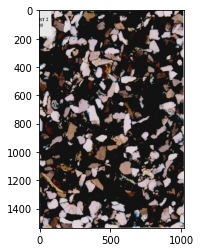

In [27]:
plt.imshow(X_databt2[60,:,:,:])

coefficient of determination: 0.3760781070539505


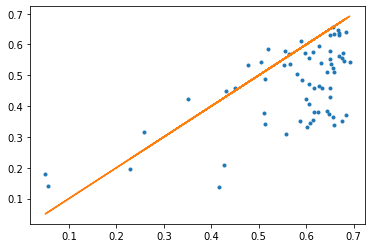

In [29]:
model = load_model('ThinSectionAE_left-model-91-11.7325-22.5732.hdf5') #max pooling added, lr -.001, filter (2,2), mpe
X_databt2_predict = model.predict(X_databt2)
plt.plot(y_databt2,X_databt2_predict,'.')
plt.plot(y_databt2,y_databt2,'-')
linear = LinearRegression()
linear.fit(y_databt2.reshape(X_databt2_predict.shape[0],X_databt2_predict.shape[1]),X_databt2_predict.reshape(X_databt2_predict.shape[0],X_databt2_predict.shape[1]))
r_sq = linear.score(y_databt2.reshape(X_databt2_predict.shape[0],X_databt2_predict.shape[1]),X_databt2_predict.reshape(X_databt2_predict.shape[0],X_databt2_predict.shape[1]))
print('coefficient of determination:', r_sq)

### Training on both datasets

In [ ]:
X_databt2=np.concatenate((X_databt2,np.flip(X_databt2,axis=1),np.flip(X_databt2,axis=2),np.flip(np.flip(X_databt2,axis=1),axis=2)),axis=0)
y_databt2=np.concatenate((y_databt2,y_databt2,y_databt2,y_databt2),axis=0)
print(X_databt2.shape)
print(y_databt2.shape)

In [ ]:
X_data = np.concatenate((X_dataA,X_databt2),axis=0)
y_data = np.concatenate((y_dataA,y_databt2),axis=0)
print(X_data.shape)
print(y_data.shape)

In [ ]:
keras.backend.clear_session()
# define input shape based on the loaded dataset
image_shape = X_train[0].shape

g_model = define_generator(image_shape)

# compile model
opt = Adam(lr=0.001, beta_1=0.5)

g_model.compile(loss='mean_absolute_percentage_error', optimizer=opt, metrics=['mse']) #, 'mae', 'mean_absolute_percentage_error

es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=50)
filepath = "ThinSectionAE_left-2wells-model-{epoch:02d}-{loss:.4f}-{val_loss:.4f}.hdf5"
checkpoint = ModelCheckpoint(filepath, monitor='val_loss', verbose=1, save_best_only=True, mode='min',period=1)

history = g_model.fit(X_train, y_train,
          epochs=200,
          batch_size=32,
          shuffle=True,
          verbose=1,
          validation_data=(X_test, y_test),
          callbacks=[checkpoint])

In [ ]:
# plot training history
plt.plot(g_model.history.history['loss'], label='train')
plt.plot(g_model.history.history['val_loss'], label='validate')
plt.xlabel('Epochs')
plt.ylabel('Loss')
#plt.title('Learning_rate=Variable')
plt.legend()
plt.show()